In [ ]:
#0
!pip install logomaker
!pip install modisco

     |████████████████████████████████| 11.8 MB 109 kB/s 
     |████████████████████████████████| 215 kB 4.2 MB/s 
     |████████████████████████████████| 1.4 MB 41.4 MB/s 
     |████████████████████████████████| 3.2 MB 39.7 MB/s 
  Created wheel for modisco: filename=modisco-0.5.15.0-py3-none-any.whl size=231925 sha256=bfa23081295c5f73b7ee57e7074bd55b395a18ab831e2cebaaf02aeb79e258f6
  Stored in directory: /root/.cache/pip/wheels/67/53/04/50094050522f2faf148096dd88651c1674c3c7a619a5c5377a
Successfully built modisco


In [ ]:
#1
import shutil

!gdown --id "1gs-gndGhvG8tcjZgAU4t_h-y2DUxytoe"
# Unpack the archive file 
shutil.unpack_archive("summer_school_files.zip") 

Downloading...
From: https://drive.google.com/uc?id=1gs-gndGhvG8tcjZgAU4t_h-y2DUxytoe
To: /content/summer_school_files.zip
73.8MB [00:01, 45.6MB/s]


In [ ]:
#2
import numpy as np
import pandas as pd
import random

import statistics
from sklearn.metrics import average_precision_score
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import pickle 

import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers

import logomaker

import utilies
from NN_IG_imp import get_integrated_gradients

# pearson correlation metric
def tf_pearson(x, y):
    mx = tf.math.reduce_mean(input_tensor=x)
    my = tf.math.reduce_mean(input_tensor=y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(input_tensor=tf.multiply(xm, ym))
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

# 1. Running IG with trained model

In [ ]:
#3
def compute_AUC_between_ideal_and_actual_interpretability_scores(actual_interpretability_scores, ideal_interpretability_scores):
    actual_interpretability_scores = np.sum(
        actual_interpretability_scores, axis=1)
    actual_interpretability_scores = np.squeeze(
        np.asarray(actual_interpretability_scores))
    ideal_interpretability_scores = np.squeeze(
        np.asarray(ideal_interpretability_scores))

    result = None
    AUC_sum = 0
    #compute AUC score for stabilizing motifs 
    positives_interpretability_scores = actual_interpretability_scores.clip(min=0)
    try:
        AUC_sum += average_precision_score(ideal_interpretability_scores.clip(min=0), positives_interpretability_scores/np.max(
            positives_interpretability_scores)) if (((ideal_interpretability_scores > 0).any()) and (positives_interpretability_scores != 0).any()) else 0
    except Exception as e:
        print("An exception occurred while trying to compute the AUC")
        print(e)

    #compute AUC score for destabilizing motifs 
    negative_interpretability_scores = -(actual_interpretability_scores.clip(max=0))  #convert into positive scores
    try:
        AUC_sum += average_precision_score(-(ideal_interpretability_scores.clip(max=0)), negative_interpretability_scores/np.max(
            negative_interpretability_scores)) if (((ideal_interpretability_scores < 0).any()) and (negative_interpretability_scores != 0).any()) else 0
    except Exception as e:
        print("An exception occurred while trying to compute the AUC")
        print(e)  

    result = AUC_sum/2 if ((ideal_interpretability_scores > 0).any()
                            and (ideal_interpretability_scores < 0).any()) else AUC_sum

    return result

def compute_average_AUC_score(actual_interpretability_scores_list, ideal_interpretability_scores_list):
    samples_num = len(actual_interpretability_scores_list)
    AUCs = [compute_AUC_between_ideal_and_actual_interpretability_scores(actual_interpretability_scores_list[i], ideal_interpretability_scores_list[i]) for i in range(samples_num)]

    print("Average AUC", statistics.mean(AUCs))
    print("std:", statistics.stdev(AUCs))   


def create_DNA_logo(PWM, figsize=(10, 2.5), labelpad=-1, ax=None):
    PWM_df = explained_seq_fetures_letters = pd.DataFrame(PWM, columns=['A', 'C', 'G', 'U'])
    IG_logo = logomaker.Logo(PWM_df,
                             shade_below=.5,
                             fade_below=.5,
                             color_scheme='classic',
                             ax=ax,
                             figsize=figsize)

    IG_logo.style_spines(visible=False)
    IG_logo.style_spines(spines=['left', 'bottom'], visible=True)
    IG_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

    # style using Axes methods
    IG_logo.ax.set_ylabel("IG", labelpad=labelpad)
    # IG_logo.ax.set_xlabel(string)
    IG_logo.ax.xaxis.set_ticks_position('none')
    IG_logo.ax.xaxis.set_tick_params('both')
    IG_logo.ax.set_xticklabels([])

    plt.show()
    return IG_logo  

In [ ]:
#4
#load validation_seq set containing 58 samples and their ideal interpretability scores
(val_x_initial, val_x_seq_features, val_y) = pickle.load(open("validation_seq_A_minus_dataset.sav", "rb" ))
validation_seq_ideal_interpretability_scores = pickle.load(open("validation_seq_ideal_interpretability_scores.sav", "rb" ))

print("val_x_initial.shape:", val_x_initial.shape)
print("val_x_seq_features.shape:", val_x_seq_features.shape)
print("val_y.shape:", val_y.shape)

val_x_initial.shape: (58, 1)
val_x_seq_features.shape: (58, 110, 4)
val_y.shape: (58, 8)


In [ ]:
#5
#load the trained model    
model = tf.keras.models.load_model("model_1.h5", custom_objects={'tf_pearson': tf_pearson})

baseline shape of x_seq_features: (110, 4)
baseline shape of x_initial: (1,)
Ideal logo of sequence number 8


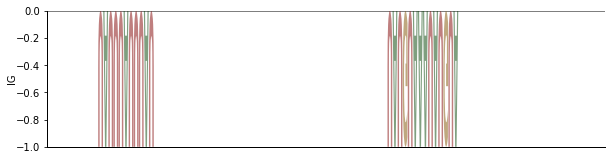

Resulted logo of sequence number 8


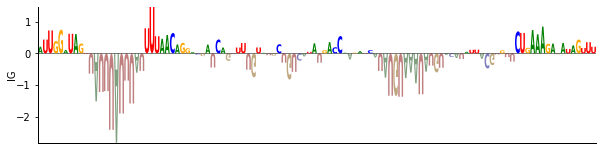

Ideal logo of sequence number 32


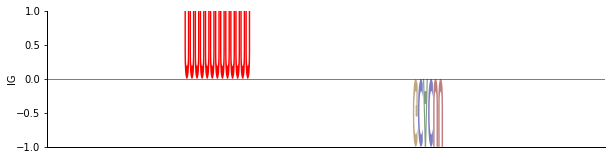

Resulted logo of sequence number 32


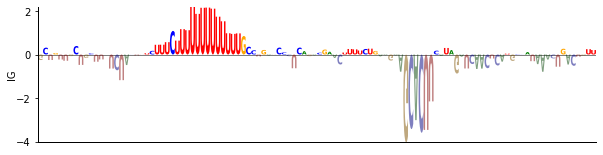

In [ ]:
#6
#set the default values for baselines and num_steps parameters 
baselines = [np.zeros(val_x_seq_features.shape[1:]), np.zeros(val_x_initial.shape[1:])]
print("baseline shape of x_seq_features:", baselines[0].shape)
print("baseline shape of x_initial:", baselines[1].shape)
num_steps = 50

(seq_features_ig_scores, initial_ig_scores) = get_integrated_gradients(model=model, sample_inputs=[val_x_seq_features, val_x_initial], baselines=baselines, num_steps=num_steps, multiple_samples=True)
for i in [7, 31]:
  print("Ideal logo of sequence number", i+1)
  create_DNA_logo(val_x_seq_features[i]*np.expand_dims(validation_seq_ideal_interpretability_scores[i],1))
  print("Resulted logo of sequence number", i+1)
  create_DNA_logo(seq_features_ig_scores[i])

In [ ]:
#7
#test the average AUC score over the samples
compute_average_AUC_score(seq_features_ig_scores, validation_seq_ideal_interpretability_scores)

Average AUC 0.6312309255391799
std: 0.42040365106666194


Now try to change the baseline and the nun_steps parameters and see the results 

**baseline**: The baseline to start with for interpolation

**num_steps**: Number of interpolation steps between the baseline and the input used in the computation of integrated gradients. These steps along determine the integral approximation error. By default, num_steps is set to 50.

**Note:** When you are using a basline that is different from the zero array, you will get atributtion scores for necludtides that does not appear in the tested sequence. Modify the code to handle this.


In [ ]:
#8
baselines = #fill
num_steps = #fill

(seq_features_ig_scores, initial_ig_scores) = get_integrated_gradients(model=model, sample_inputs=[val_x_seq_features, val_x_initial], baselines=baselines, num_steps=num_steps, multiple_samples=True)

########Add Hereyour modification in case of not using the zero baseline########

################################################################################

example_seqs_ids = #fill with a list of seuqnces ids for visualisation (there are 58 validation sequences), for example [7, 31]
for i in example_seqs_ids:
  print("Ideal logo of sequence number", i+1)
  create_DNA_logo(val_x_seq_features[i]*np.expand_dims(validation_seq_ideal_interpretability_scores[i],1))
  print("Resulted logo of sequence number", i+1)
  create_DNA_logo(seq_features_ig_scores[i])

#test the average AUC score over the samples
compute_average_AUC_score(seq_features_ig_scores, validation_seq_ideal_interpretability_scores)

# 2. Training your own model and testing your IG scores

In [ ]:
#9
def evaluate_model(y_predicted, y_observed):
    y_predicted = np.squeeze(np.asarray(y_predicted))
    y_observed = np.squeeze(np.asarray(y_observed))


    num_of_samples = len(y_predicted)
    metrics_results = {'pearson': np.zeros((num_of_samples,)), 'RMSE': np.zeros((num_of_samples,))}
    for i in range(num_of_samples):
        y_predicted_i = y_predicted[i, :]
       
        metrics_results['pearson'][i] = pearsonr(y_predicted_i, y_observed[i, :])[0]
        metrics_results['RMSE'][i] = mean_squared_error( y_observed[i, :], y_predicted_i, squared=False)


    #compute mean and std for each metric and return the results
    means_and_stds = {}
    for key in metrics_results:
          means_and_stds[key+'_mean'] = np.mean(metrics_results[key])
          means_and_stds[key+'_std'] = np.std(metrics_results[key])
    print(pd.DataFrame([means_and_stds]).to_string(index=False))

In [ ]:
#10
def model_creation_and_fit (train_set_wrapper,  validation_set_wrapper, model_params):
    #unwrap tarin and validation set
    (train_x_intial, train_x, train_y, train_weights) = train_set_wrapper
    (validation_x_intial, validation_x, validation_y) = validation_set_wrapper

    #combine intial and one-hot to list for future use
    train_x = [train_x, train_x_intial]
    validation_x =[validation_x, validation_x_intial]

    output_shape = train_y.shape[1]
    
    #create layers
    input1 = layers.Input(shape=(train_x[0].shape[1], train_x[0].shape[2]))
    input2 = layers.Input(shape=(train_x_intial.shape[1],))

    x = layers.Conv1D(filters=128, #fill! for example with 128
                      kernel_size=10, #fill! for example with 10
                      strides=1,
                      kernel_initializer='glorot_uniform',
                      activation='relu', #fill! for example with 'relu'
                      kernel_regularizer=regularizers.l2(l2=0.01), #fill with kernel_regularizer_lambda! for example with 0.01                             
                      padding="valid",
                      use_bias=True,
                      bias_initializer='glorot_uniform')(input1)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([x, input2])

    dense_units_list = [128] #fill! for example [128]
    activation_list = ['relu'] #fill! for example ['relu']
    dropout_rate_list = [0.1] #fill! for example [0.1]
    for i in range(len(dense_units_list)):
      x = layers.Dense(units=dense_units_list[i],
                     activation=activation_list[i])(x)

      if(dropout_rate_list[i]>0):
        x= layers.Dropout(rate=dropout_rate_list[i])(x)

    output = layers.Dense(units=output_shape,
                          activation='linear')(x)
    
    #define inputs-outputs and complie model
    model = Model(inputs=[input1, input2], outputs=output)

    #print model description summary
    print (model.summary())    
    

    optimizer = tf.keras.optimizers.get({"class_name": model_params['optimizer'], "config": {"learning_rate": model_params['lr']}})
    model.compile(loss=model_params['loss'], optimizer=optimizer, metrics=['mse', tf_pearson, 'mae'])
    
    #create callbacks
    callbacks = []
    callbacks.append(tf.keras.callbacks.TerminateOnNaN())
    
    #fit
    model.fit(train_x,
              train_y,
              validation_data=(validation_x, validation_y),
              shuffle=True,
              epochs=model_params['epochs'],                             
              batch_size= model_params['batch_size'],
              verbose=2,
              sample_weight=train_weights,
              callbacks=callbacks)
    
    return model

In [ ]:
#11
#load training, validation, and test sets
(train_set_wrapper, validation_set_wrapper, test_set_wrapper) = pickle.load(open("A_minus_dataset_minimal_cov.sav", "rb" ))
print("Train set:", len(train_set_wrapper[0]), "samples")
print("Validation set:", len(validation_set_wrapper[0]), "samples")
print("Test set:", len(test_set_wrapper[0]), "samples")

Train set: 26232 samples
Validation set: 5087 samples
Test set: 4004 samples


In [ ]:
#12
model_params = {'loss':'mse', 'optimizer':'Adam', 'lr':0.005, 'epochs':30, 'batch_size':64}
your_model = model_creation_and_fit(train_set_wrapper,  validation_set_wrapper, model_params)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 110, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 101, 128)     5248        input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           conv1d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
#13
#unwrap the test set  
(x_initial_test, x_seq_features_test, y_observed_test) = test_set_wrapper

#evluate the prediction performance of the original model 
y_predicted_test = model.predict([x_seq_features_test, x_initial_test])
print("original model prediction performance:")
evaluate_model(y_predicted_test, y_observed_test)

#evluate the prediction performance of the your model 
y_predicted_test = your_model.predict([x_seq_features_test, x_initial_test])
print("your model prediction performance:")
evaluate_model(y_predicted_test, y_observed_test)

original model prediction performance:
 pearson_mean  pearson_std  RMSE_mean  RMSE_std
     0.960309     0.046782   0.537297  0.287579
your model prediction performance:
 pearson_mean  pearson_std  RMSE_mean  RMSE_std
     0.949381     0.057716   0.590315  0.309245


Ideal logo of sequence number 8


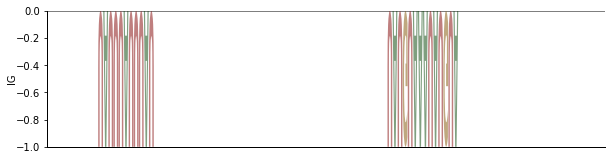

Resulted logo of sequence number 8


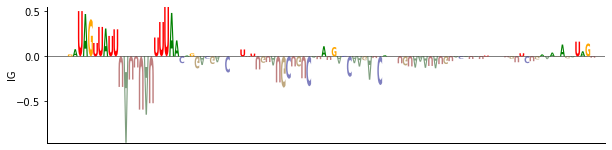

Ideal logo of sequence number 32


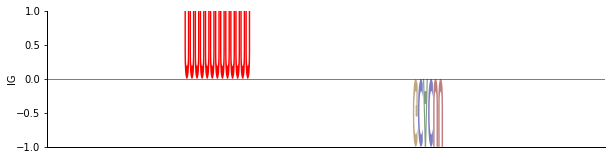

Resulted logo of sequence number 32


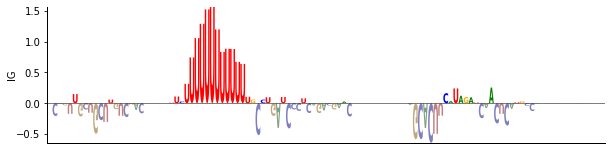

Average AUC 0.3596152631608757
std: 0.3370191765096844


In [ ]:
#14
(seq_features_ig_scores, initial_ig_scores) = get_integrated_gradients(model=your_model, sample_inputs=[val_x_seq_features, val_x_initial], baselines=baselines, num_steps=num_steps, multiple_samples=True)
for i in [7, 31]:
  print("Ideal logo of sequence number", i+1)
  create_DNA_logo(val_x_seq_features[i]*np.expand_dims(validation_seq_ideal_interpretability_scores[i],1))
  print("Resulted logo of sequence number", i+1)
  create_DNA_logo(seq_features_ig_scores[i])

#test the average AUC score over the samples
compute_average_AUC_score(seq_features_ig_scores, validation_seq_ideal_interpretability_scores)

# 3. Interpretability with Lasso model and improving the CNN model interpretability using an ensemble model

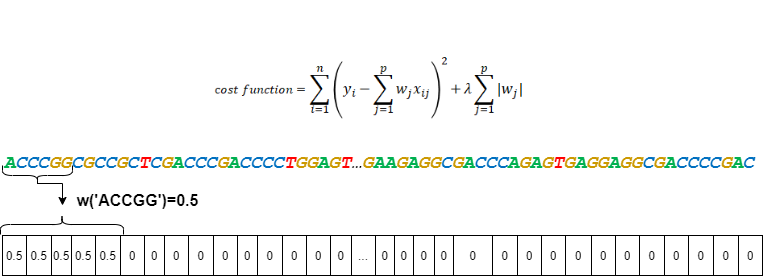

In [ ]:
#15
def seq_interpretability_score(seq, kmer_scores):
    s_score = np.zeros(len(seq))
    kmers_len_range = range(3,8)
    for i in kmers_len_range:
        for j in range(0, len(seq)+1-i):
            s_score[j:j+i] = s_score[j:j+i] + kmer_scores[seq[j:j+i]]

    s_score_expend = np.zeros((len(seq), 4))
    nec_to_pos = {'A':0, 'C':1, 'G':2, 'T':3}
    for i in range(len(seq)):
        s_score_expend[i,nec_to_pos[seq[i]]] = s_score[i]

    return s_score_expend    

def draw_seq_interpretability(seq, kmer_scores):
    s_score_expend = seq_interpretability_score(seq, kmer_scores)
    explained_seq_fetures_letters = pd.DataFrame(s_score_expend, columns=['A', 'C', 'G', 'U'])
    create_DNA_logo(explained_seq_fetures_letters)

Ideal logo of sequence number 8


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Lasso from version 0.23.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


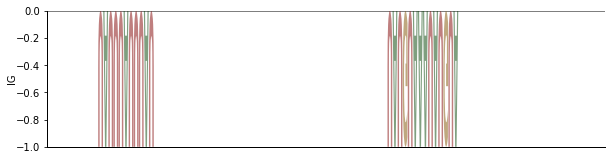

(Lasso) Resulted logo of sequence number 8


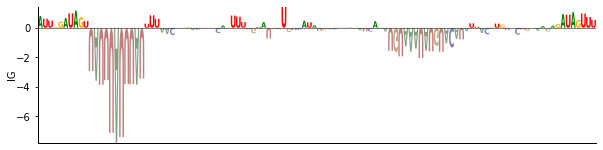

Ideal logo of sequence number 32


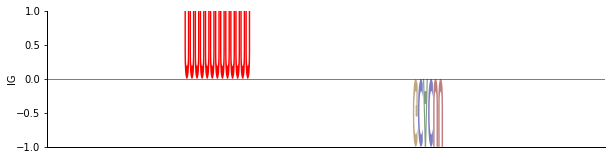

(Lasso) Resulted logo of sequence number 32


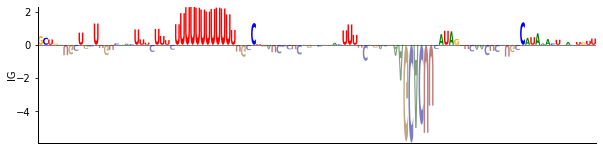

In [ ]:
#16
#load the lasso model
lasso_model = pickle.load(open("loss_weights_lasso_8_model_A_minus_disjoint.sav", 'rb'))
#create all possible kmer of len 3-7
allKmers = utilies.retutnAllKmers(3, 7)
#for each kmer assign as score its feature weight 
kmer_scores = dict(zip(allKmers, lasso_model.coef_.sum(axis=0)))

#laod the 58 validation scores
validation_seqs = pd.read_csv('validation_seq.csv')['seq']

for i in [7, 31]:
  print("Ideal logo of sequence number", i+1)
  create_DNA_logo(val_x_seq_features[i]*np.expand_dims(validation_seq_ideal_interpretability_scores[i],1))
  print("(Lasso) Resulted logo of sequence number", i+1)
  draw_seq_interpretability(validation_seqs[i], kmer_scores)

In [ ]:
#17
#test the average AUC score over the samples
seq_features_lasso_scores = [seq_interpretability_score(validation_seqs[i], kmer_scores) for i in range(len(validation_seqs))]
compute_average_AUC_score(seq_features_lasso_scores, validation_seq_ideal_interpretability_scores)

Average AUC 0.6812481496434065
std: 0.4267715521293249


**improving the CNN model interpretability using an ensemble model**

In [ ]:
#18
#load the trained models  
models_list = [tf.keras.models.load_model("model_{}.h5".format(i), custom_objects={'tf_pearson': tf_pearson}) for i in range(1,11)]
ig_scores_list = [get_integrated_gradients(model=model_i, sample_inputs=[val_x_seq_features, val_x_initial], multiple_samples=True)[0] for model_i in models_list]
seq_features_ig_scores = np.mean(ig_scores_list, axis=0)

Ideal logo of sequence number 8


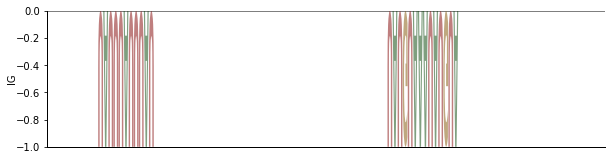

Resulted logo of sequence number 8


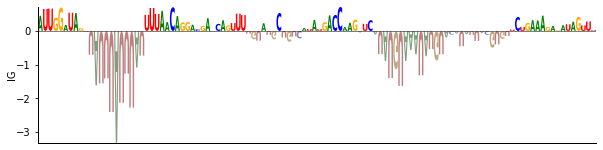

Ideal logo of sequence number 32


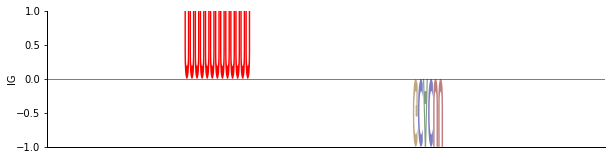

Resulted logo of sequence number 32


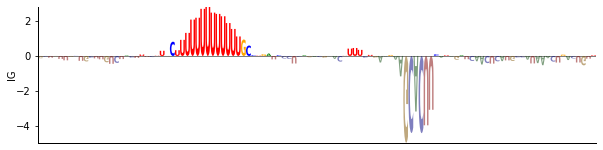

Average AUC 0.6854605092756382
std: 0.43489989327454803


In [ ]:
#19
for i in [7, 31]:
  print("Ideal logo of sequence number", i+1)
  create_DNA_logo(val_x_seq_features[i]*np.expand_dims(validation_seq_ideal_interpretability_scores[i],1))
  print("Resulted logo of sequence number", i+1)
  create_DNA_logo(seq_features_ig_scores[i])

#test the average AUC score over the samples
compute_average_AUC_score(seq_features_ig_scores, validation_seq_ideal_interpretability_scores)

In [ ]:
#20
#evluate the prediction performance of the ensemble model 
y_predicted_test = model.predict([x_seq_features_test, x_initial_test])
print("original model performance:")

y_predicted_test_list = [model_i.predict([x_seq_features_test, x_initial_test]) for model_i in models_list]
y_predicted_test = np.mean(y_predicted_test_list, axis=0)
evaluate_model(y_predicted_test, y_observed_test)

original model performance:
 pearson_mean  pearson_std  RMSE_mean  RMSE_std
     0.962827     0.042234   0.509392  0.259766


# 4. Does sequecne elmenent has different effect in different time points?

Resulted logo of sequence number 3
2hpf


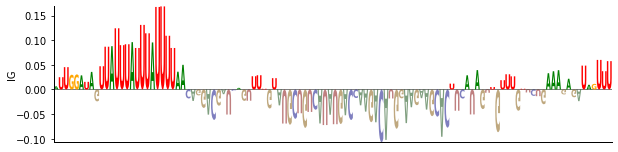

3hpf


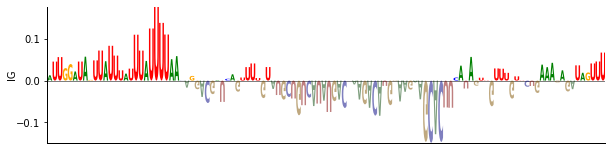

4hpf


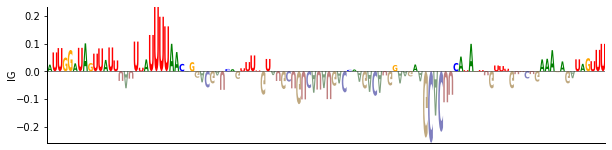

5hpf


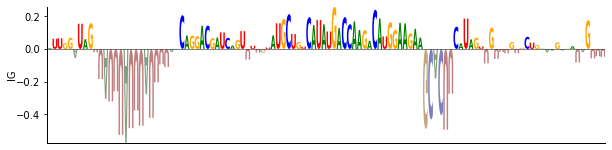

6hpf


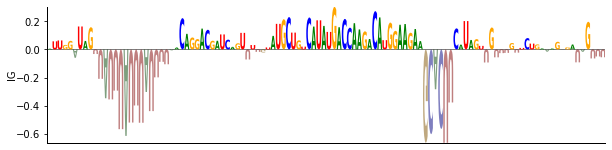

7hpf


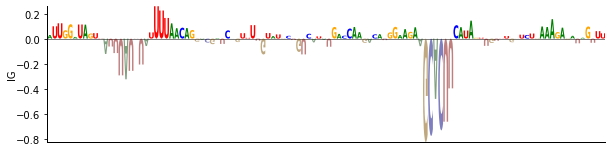

8hpf


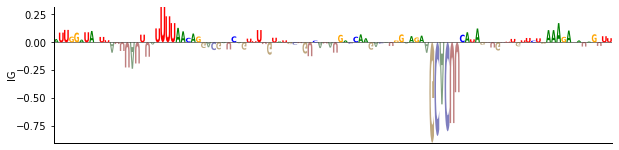

10hpf


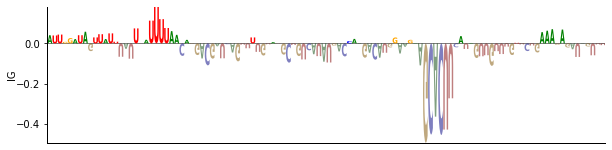

In [ ]:
#21
ig_list = [get_integrated_gradients(model=model, sample_inputs=[val_x_seq_features, val_x_initial], multiple_samples=True, target_range=slice(i,i+1)) for i in range(8)]
hpfs = [2,3,4,5,6,7,8,10]
for i in [2]:
  print("Resulted logo of sequence number", i+1)
  for j in range(8):
    (seq_features_ig_scores, initial_ig_scores) = ig_list[j]
    print("{}hpf".format(hpfs[j]))
    create_DNA_logo(seq_features_ig_scores[i])

#5. Does the sequence element position effect the mRNA degradation rate? 

In [ ]:
#22
def mofit_embedding_random_linear_model(model_path, n=100, seq_len=110):
    seq_elements = ('TATTTATTTAT',  # ARE destabilizing
                         'GCACTT',  # m430 destabilizing
                         'TTTTTTTTTTTTT',  # polyU stabilizing
                         'TATGTAAATATGTA'
                            )  # PUM destabilizing
    #create n random sequences
    seqs = [''.join(random.choices("ACGT", k=seq_len)) for i in range(n)]

    for element in seq_elements:
        element_one_hot_features = utilies.one_hot_encoding(element)
        motif_len = len(element_one_hot_features)
        n_modified_seq_one_hot_features_list = []
        for seq_index in range(n):
            seq_one_hot_features = utilies.one_hot_encoding(seqs[seq_index])
            modified_seq_one_hot_features_list = []
            for i in range(seq_len-motif_len):
                modified_seq_one_hot_features_list.append(np.concatenate([seq_one_hot_features[:i], element_one_hot_features, seq_one_hot_features[i+motif_len:]]))

            modified_seq_one_hot_features_array = np.stack(modified_seq_one_hot_features_list, axis=0)
            n_modified_seq_one_hot_features_list.append(modified_seq_one_hot_features_array)

        n_modified_seq_one_hot_features_array = np.concatenate(n_modified_seq_one_hot_features_list, axis=0)
        # load model
        if type(model_path) is list:
            model_list = [tf.keras.models.load_model(model_path_item, custom_objects={
                                                    'tf_pearson': tf_pearson}) for model_path_item in model_path]
        else:
            model_list = [tf.keras.models.load_model(
                model_path, custom_objects={'tf_pearson': tf_pearson})]

        model_num = len(model_list)
        for i in range(model_num):
            predicted = model_list[i].predict(n_modified_seq_one_hot_features_array)
            validation_predicted = predicted if i == 0 else validation_predicted + predicted

        validation_predicted = validation_predicted/model_num
        
        #plot Moving average of the average mRNA degradation rate
        validation_predicted_avg = np.array([np.sum(validation_predicted[i::seq_len-motif_len]) for i in range(seq_len-motif_len)])/n
        plt.scatter(range(len(validation_predicted_avg)), validation_predicted_avg, s=0.5)
        window_width = 10
        cumsum_vec = np.cumsum(np.insert(validation_predicted_avg, 0, [validation_predicted_avg[0]]*(window_width-1))) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(ma_vec, label="Moving average, window size of "+str(window_width))
        plt.ylabel("Degradation rate")
        plt.xlabel("Motif strating position")
        plt.title("Motif '"+element+"'")
        plt.legend()
        plt.savefig("Motif_"+element+"random_n_"+str(n)+".png")
        plt.show()
        plt.clf()


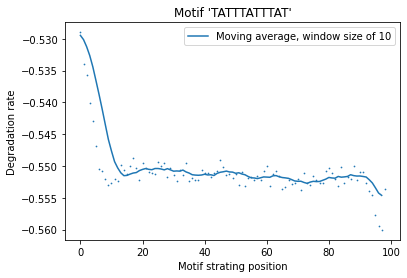

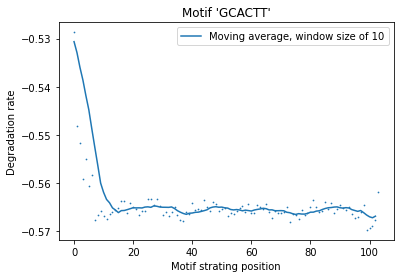

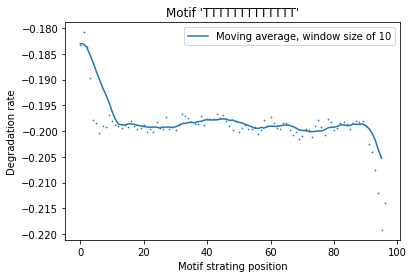

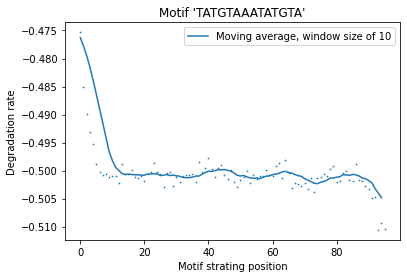

<Figure size 432x288 with 0 Axes>

In [ ]:
#23
mofit_embedding_random_linear_model('linear_model.h5', n=1000, seq_len=110)

#6. Global interpretability with TF-Modisco

**hypothetical importance** are improtance scores that if other unobserved bases were present. A hypothetical importance score answers the question “if I were to mutate the sequence at a particular position to a different letter, what would the importance on the newly-introduced letter look like?”


***parameters:***

**target_seqlet_fdr** - controls the noisiness of the seqlets


**kmer_len, num_gaps and num_mismatches** - Gapped k-mers (potentially allowing for mismatches) are identified in the seqlet by scanning the one-hot encoded sequence.

In [ ]:
#24
import os
import h5py

import modisco
import modisco.visualization
from modisco.visualization import viz_sequence

from pathlib import Path
Path("modisco_out").mkdir(parents=True, exist_ok=True)

def savePattern(patten,filename,LEN=70):
    raw_data = {'Pos':np.arange(len(patten))+1,'A': patten[:,0],'C': patten[:,1],'G': patten[:,2],'T': patten[:,3]}
    df = pd.DataFrame(raw_data, columns = ['Pos','A','C','G','T'])
    np.savetxt(filename, df.values, fmt='%i\t%0.6f\t%0.6f\t%0.6f\t%0.6f', delimiter="\t", header="Pos\tA\tC\tG\tT",comments='')


def run_modisco(hyp_impscores, impscores, onehot_data):
    nulldist_args = {}
    #Run TF-MoDISco
    tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
        target_seqlet_fdr=0.25, #fill 
        seqlets_to_patterns_factory=
            modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory
            (
            #Adjust trim_to_window_size and initial_flank_to_add
            # according to how big you expect
            # the core motif to be; default value is 10
            #trim_to_window_size=6,
            #initial_flank_to_add=2,
            #final_flank_to_add=5,
            #kmer_len, num_gaps and num_mismatches are used to
            # derive kmer embeddings for coarse-grained affinity
            # matrix calculation. kmer_len=6, num_gaps=1
            # and num_mismatches=0 means
            # that kmer embeddings using 6-mers with 1 gap will be
            # used.
            kmer_len=6, #fill
            num_gaps=1, #fill
            num_mismatches=0 #fill
            )
        )(
            #There is only one task, so we just call this 'task0'
            task_names=["task0"],
            contrib_scores={'task0': impscores},                
            hypothetical_contribs={'task0': hyp_impscores},
            one_hot=onehot_data,
            **nulldist_args
            )
    
    grp = h5py.File("results.hdf5", "w")
    tfmodisco_results.save_hdf5(grp)
    grp.close()

  
    hdf5_results = h5py.File("results.hdf5","r")

    print("Metaclusters heatmap")
    import seaborn as sns
    activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                        np.array(
            [x[0] for x in sorted(
                    enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
                   key=lambda x: x[1])])]
    sns.heatmap(activity_patterns, center=0)
    plt.show()

    metacluster_names = [
        x.decode("utf-8") for x in 
        list(hdf5_results["metaclustering_results"]
             ["all_metacluster_names"][:])]

    all_patterns = []
    print(metacluster_names)
    for metacluster_name in metacluster_names:
        print(metacluster_name)
        metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                       [metacluster_name])
        print("activity pattern:",metacluster_grp["activity_pattern"][:])
        all_pattern_names = [x.decode("utf-8") for x in 
                             list(metacluster_grp["seqlets_to_patterns_result"]
                                                 ["patterns"]["all_pattern_names"][:])]
        if (len(all_pattern_names)==0):
            print("No motifs found for this activity pattern")
        for i,pattern_name in enumerate(all_pattern_names):
            print(metacluster_name, pattern_name)
            all_patterns.append((metacluster_name, pattern_name))
            pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
            print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
            background = np.array([0.27, 0.23, 0.23, 0.27])
            print("Hypothetical scores:")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
            plt.show()
            plt.savefig('modisco_out/'+'Hypothetical'+str(i)+'.png')
            print("Actual importance scores:")
            viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
            plt.show()
            plt.savefig('modisco_out/'+'importance'+str(i)+'.png')
            print("onehot, fwd and rev:")
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                            background=background)) 
            plt.show()
            plt.savefig('modisco_out/'+'onehot_fwd'+str(i)+'.png')
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                            background=background))
            plt.savefig('modisco_out/'+'onehot_rev'+str(i)+'.png')
            savePattern(np.array(pattern["task0_hypothetical_contribs"]["fwd"]),"modisco_out/hyp_pattern"+str(i)+".txt")
            savePattern(np.array(pattern["task0_contrib_scores"]["fwd"]),"modisco_out/imp_pattern"+str(i)+".txt")
            savePattern(np.array(pattern["sequence"]["fwd"]),"modisco_out/onehot_pattern"+str(i)+".txt")

    hdf5_results.close()

In [ ]:
#25
[hyp_impscores, impscores, onehot_data, _] = pickle.load(open('minimal_cov_modisco_input_model_8_points_id_1_inter_A_minus_all_outputs_validation_and_test_set.sav', 'rb'))

Instructions for updating:
non-resource variables are not supported in the long term
MEMORY 3.824693248
On task task0
Computing windowed sums on original
Generating null dist


TF-MoDISco is using the TensorFlow backend.


peak(mu)= -3.5247482007145883
Computing threshold
For increasing = True , the minimum IR precision was 0.3650570187637733 occurring at 2.4080276489257812e-05 implying a frac_neg of 0.5749445691217996
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35596097548476363 occurring at -0.00010585784912109375 implying a frac_neg of 0.5527009419230348
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -42.107521057128906  and  27.987909078598022 with frac passing 0.00158
Passing windows frac was 0.00158 , which is below  0.03 ; adjusting
Final raw thresholds are -15.135135210752487  and  15.135135210752487
Final transformed thresholds are -0.97  and  0.97


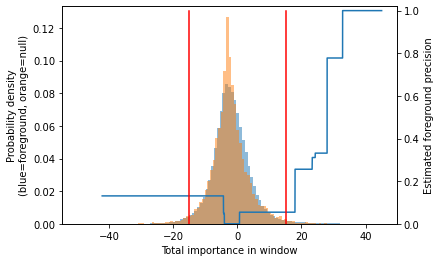

Got 1144 coords
After resolving overlaps, got 1144 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699
MEMORY 3.828416512
1144 identified in total
2 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [699, 445]
Idx to activities:  {0: '-1', 1: '1'}
MEMORY 3.828416512
On metacluster 1
Metacluster size 445
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 445
(Round 1) Computing coarse affmat
MEMORY 3.828506624
Beginning embedding computation
MEMORY 3.828506624
Computing embeddings
Finished embedding computation in 0.61 s
MEMORY 3.841728512
Starting affinity matrix computations
MEMORY 3.841728512
Batching in slices of size 445


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

Finished affinity matrix computations in 0.21 s
MEMORY 3.843493888


(Round 1) Computed coarse affmat
MEMORY 3.843493888
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 3.843493888
Launching nearest neighbors affmat calculation job
MEMORY 3.843493888
Parallel runs completed
MEMORY 3.843772416
Job completed in: 10.15 s
MEMORY 3.843772416
Launching nearest neighbors affmat calculation job
MEMORY 3.843772416
Parallel runs completed
MEMORY 3.843751936
Job completed in: 10.05 s
MEMORY 3.843751936
(Round 1) Computed affinity matrix on nearest neighbors in 20.45 s
MEMORY 3.843751936
Filtered down to 423 of 445
(Round 1) Retained 423 rows out of 445 after filtering
MEMORY 3.843751936
(Round 1) Computing density adapted affmat
MEMORY 3.8506496
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 3.84806912
Beginning preprocessing + Leiden
Affmat shape: 423


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.2s


Quality: 0.01026391006892233
Quality: 0.010512077640180388
Quality: 0.010518587632973175
Got 3 clusters after round 1
Counts:
{1: 169, 0: 207, 2: 47}
MEMORY 3.849232384
(Round 1) Aggregating seqlets in each cluster
MEMORY 3.849232384
Aggregating for cluster 0 with 207 seqlets
MEMORY 3.849232384
Skipped 3 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   16.4s finished


Skipped 5 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 74 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 122
Skipped 52 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 169 seqlets
MEMORY 3.84897024
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 49 seqlets that went over sequence edge during flank expansion
Skipped 3 seqlets that were requiring other seqlets to go over the edge during flank expansion
Trimming eliminated 0 seqlets out of 115
Skipped 40 seqlets that wen

100%|██████████| 1/1 [00:00<00:00, 40.77it/s]

Finished affinity matrix computations in 0.05 s
MEMORY 4.033417216
(Round 2) Computed coarse affmat
MEMORY 4.033417216
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 4.033417216


Launching nearest neighbors affmat calculation job
MEMORY 4.033417216
Parallel runs completed
MEMORY 4.033466368
Job completed in: 1.94 s
MEMORY 4.033466368
Launching nearest neighbors affmat calculation job
MEMORY 4.033466368
Parallel runs completed
MEMORY 4.033437696
Job completed in: 2.04 s
MEMORY 4.033437696
(Round 2) Computed affinity matrix on nearest neighbors in 4.16 s
MEMORY 4.033462272
Not applying filtering for rounds above first round
MEMORY 4.033462272
(Round 2) Computing density adapted affmat
MEMORY 4.033462272
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 4.0348672
Beginning preprocessing + Leiden
Affmat shape: 163


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s


Quality: 0.017694030509249784
Quality: 0.017766441018344653
Got 5 clusters after round 2
Counts:
{0: 66, 3: 29, 2: 32, 1: 35, 4: 1}
MEMORY 4.034605056
(Round 2) Aggregating seqlets in each cluster
MEMORY 4.034605056
Aggregating for cluster 0 with 66 seqlets
MEMORY 4.034605056


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.9s finished


Trimming eliminated 0 seqlets out of 66
Skipped 10 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 35 seqlets
MEMORY 4.034605056
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 34
Skipped 11 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 32 seqlets
MEMORY 4.034605056
Skipped 1 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 31
Skipped 8 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 29 seqlets
MEMORY 4.034605056
Trimming eliminated 0 seqlets out of 29
Skipped 3 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 4 with 1 seqlets
MEMORY 4.034605056
Trimming eliminated 0 seqlets out of 1
Dropping cluster 4 with 1 seqlets due to sign disagreement
Got 4 clusters
Splitting into subclusters...
MEMORY 4.0346050

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 out of  56 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s


Quality: 0.04674639007051145
Got subclusters: Counter({1: 20, 0: 20, 2: 16})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.0s finished


Numbers for each pattern pre-subsample: [20, 20, 16]
Numbers after subsampling: [20, 20, 16]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.1595747470855713 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.1669323444366455 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.11902427673339844 s
Cluster sizes
[20 20 16]
Cross-contamination matrix:
[[1.   0.61 0.56]
 [0.75 1.   0.68]
 [0.85 0.86 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.92 0.91]
 [0.92 1.   0.97]
 [0.91 0.97 1.  ]]
Collapsing 1 & 2 with crosscontam 0.6773750000000001 and sim 0.9665560579004144
Collapsing 0 & 1 with crosscontam 0.6066750000000001 and sim 0.9220664710780048
Collapsing 0 & 2 with crosscontam 0.5642187500000002 and sim 0.9120103041483894
Trimming eliminated 0 seqlets out of 36
Trimming eliminated 0 seqlets out of 56
Skipped 4 seqlets that went over the sequence edge during flank expansion
Unmerged patterns remapping: OrderedDict()
Time spent on merging iteration:

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Iteration 250: error = 47.8877182, gradient norm = 0.6341363 (50 iterations in 0.023s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.887718
[t-SNE] Iteration 300: error = 0.7991459, gradient norm = 0.0021289 (50 iterations in 0.017s)
[t-SNE] Iteration 350: error = 0.6638885, gradient norm = 0.0009118 (50 iterations in 0.017s)
[t-SNE] Iteration 400: error = 0.6276666, gradient norm = 0.0004848 (50 iterations in 0.016s)
[t-SNE] Iteration 450: error = 0.6027920, gradient norm = 0.0004918 (50 iterations in 0.017s)
[t-SNE] Iteration 500: error = 0.5885996, gradient norm = 0.0002633 (50 iterations in 0.015s)
[t-SNE] Iteration 550: error = 0.5766799, gradient norm = 0.0002731 (50 iterations in 0.016s)
[t-SNE] Iteration 600: error = 0.5705936, gradient norm = 0.0001684 (50 iterations in 0.015s)
[t-SNE] Iteration 650: error = 0.5547360, gradient norm = 0.0003790 (50 iterations in 0.015s)
[t-SNE] Iteration 700: error = 0.5496728, gradient norm = 0.0003592 (50 ite

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s


Quality: 0.08828454916638731
Quality: 0.08911414415885115
Quality: 0.09048243812162997
Got subclusters: Counter({0: 24, 1: 15, 2: 15, 3: 13})
On metacluster 0
Metacluster size 699
Relevant tasks:  ('task0',)
Relevant signs:  (-1,)


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.5s finished


TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 699
(Round 1) Computing coarse affmat
MEMORY 4.035067904
Beginning embedding computation
MEMORY 4.035067904
Computing embeddings
Finished embedding computation in 0.65 s
MEMORY 4.051853312
Starting affinity matrix computations
MEMORY 4.051853312
Batching in slices of size 699


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

Finished affinity matrix computations in 0.32 s
MEMORY 4.052750336
(Round 1) Computed coarse affmat
MEMORY 4.052750336
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 4.052750336


Launching nearest neighbors affmat calculation job
MEMORY 4.052750336
Parallel runs completed
MEMORY 4.052733952
Job completed in: 17.38 s
MEMORY 4.052733952
Launching nearest neighbors affmat calculation job
MEMORY 4.052733952
Parallel runs completed
MEMORY 4.052709376
Job completed in: 17.69 s
MEMORY 4.052709376
(Round 1) Computed affinity matrix on nearest neighbors in 35.38 s
MEMORY 4.05276672
Filtered down to 675 of 699
(Round 1) Retained 675 rows out of 699 after filtering
MEMORY 4.05276672
(Round 1) Computing density adapted affmat
MEMORY 4.065087488
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 4.058607616
Beginning preprocessing + Leiden
Affmat shape: 675


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.4s


Quality: 0.1697914186507377
Got 2 clusters after round 1
Counts:
{1: 332, 0: 343}
MEMORY 4.059471872
(Round 1) Aggregating seqlets in each cluster
MEMORY 4.059471872
Aggregating for cluster 0 with 343 seqlets
MEMORY 4.059471872


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   21.0s finished


Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 133 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 207
Skipped 83 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 332 seqlets
MEMORY 4.059471872
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 4 seqlets that went over the sequence edge during flank expansion
Skipped 115 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 209
Skipped 74 seqlets that went over the sequence edge during flank expansion
(Round 2) num seqlets: 259
(Round 2) Computing coarse affmat
MEMORY 4.058423296
Beginning embedding computation
MEMORY 4.058423296
Computing embeddings
Finished embedding computation in 0.5 s
MEMORY 4.058423296
Starting affinity matrix computations
MEMORY 4.05842329

100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

Finished affinity matrix computations in 0.09 s
MEMORY 4.058423296


(Round 2) Computed coarse affmat
MEMORY 4.058423296
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 4.058423296
Launching nearest neighbors affmat calculation job
MEMORY 4.058423296
Parallel runs completed
MEMORY 4.058402816
Job completed in: 5.85 s
MEMORY 4.058402816
Launching nearest neighbors affmat calculation job
MEMORY 4.058402816
Parallel runs completed
MEMORY 4.05837824
Job completed in: 5.75 s
MEMORY 4.05837824
(Round 2) Computed affinity matrix on nearest neighbors in 11.81 s
MEMORY 4.058427392
Not applying filtering for rounds above first round
MEMORY 4.058427392
(Round 2) Computing density adapted affmat
MEMORY 4.0608768
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 4.060540928
Beginning preprocessing + Leiden
Affmat shape: 259


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s


Quality: 0.07528758246915597
Got 3 clusters after round 2
Counts:
{0: 126, 1: 117, 2: 16}
MEMORY 4.060540928
(Round 2) Aggregating seqlets in each cluster
MEMORY 4.060540928
Aggregating for cluster 0 with 126 seqlets
MEMORY 4.060540928


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.1s finished


Skipped 21 seqlets that went over the sequence edge during flank expansion
Skipped 2 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 103
Skipped 44 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 117 seqlets
MEMORY 4.060540928
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 29 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 86
Skipped 45 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 16 seqlets
MEMORY 4.060540928
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 4 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 8
Skipped 7 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that we

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 out of  59 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  59 out of  59 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s


Quality: 0.07400021527693398
Got subclusters: Counter({0: 24, 1: 18, 2: 17})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.0s finished


Numbers for each pattern pre-subsample: [24, 18, 17]
Numbers after subsampling: [24, 18, 17]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.14612698554992676 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.12687444686889648 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.1163187026977539 s
Cluster sizes
[24 18 17]
Cross-contamination matrix:
[[1.   0.26 0.18]
 [0.94 1.   0.48]
 [0.98 0.79 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.84 0.84]
 [0.84 1.   0.81]
 [0.84 0.81 1.  ]]
Inspecting pattern 1 for spurious merging
Merging on 4 clusters
MEMORY 4.060540928
On merging iteration 1
Numbers for each pattern pre-subsample: [24, 18, 17, 41]
Numbers after subsampling: [24, 18, 17, 41]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.22057700157165527 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.18180561065673828 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.17475032806396484 s
Computing sims 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Iteration 550: error = 0.5686767, gradient norm = 0.0000505 (50 iterations in 0.021s)
[t-SNE] Iteration 600: error = 0.5687463, gradient norm = 0.0000635 (50 iterations in 0.010s)
[t-SNE] Iteration 650: error = 0.5657166, gradient norm = 0.0002923 (50 iterations in 0.011s)
[t-SNE] Iteration 700: error = 0.8605902, gradient norm = 0.0258001 (50 iterations in 0.010s)
[t-SNE] Iteration 750: error = 0.6042331, gradient norm = 0.0005198 (50 iterations in 0.010s)
[t-SNE] Iteration 800: error = 0.5761915, gradient norm = 0.0001354 (50 iterations in 0.010s)
[t-SNE] Iteration 850: error = 0.5732619, gradient norm = 0.0000522 (50 iterations in 0.016s)
[t-SNE] Iteration 900: error = 0.5715601, gradient norm = 0.0000527 (50 iterations in 0.010s)
[t-SNE] Iteration 950: error = 0.5708405, gradient norm = 0.0000323 (50 iterations in 0.010s)
[t-SNE] Iteration 1000: error = 0.5705047, gradient norm = 0.0000205 (50 iterations in 0.010s)
[t-SNE] Iteration 1000: did not make any progress during th

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s


Quality: 1.8185453143360052e-13


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.3s finished


Got subclusters: Counter({0: 41})
Metaclusters heatmap


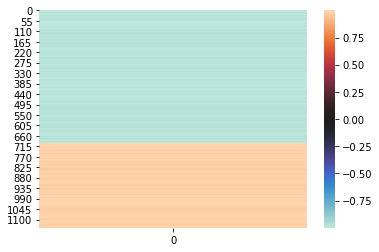

['metacluster_0', 'metacluster_1']
metacluster_0
activity pattern: [-1]
metacluster_0 pattern_0
total seqlets: 41
Hypothetical scores:


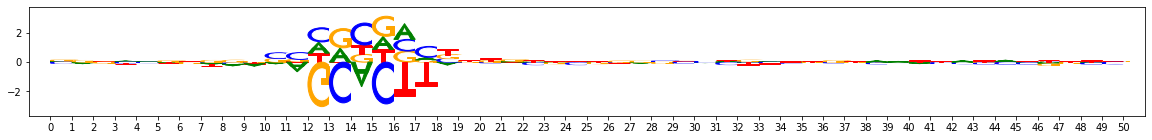

Actual importance scores:


<Figure size 432x288 with 0 Axes>

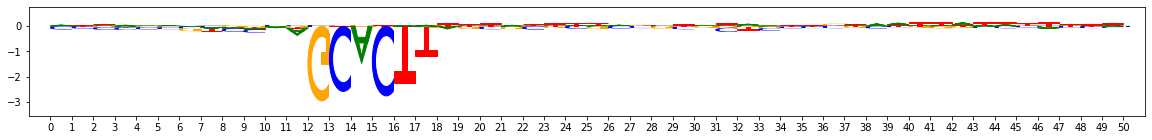

onehot, fwd and rev:


<Figure size 432x288 with 0 Axes>

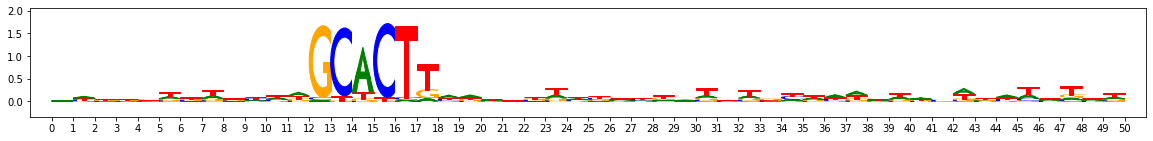

<Figure size 432x288 with 0 Axes>

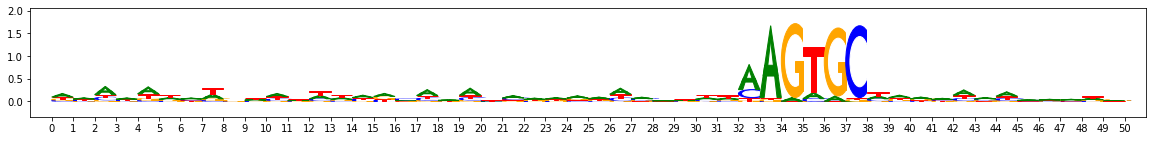

metacluster_1
activity pattern: [1]
metacluster_1 pattern_0
total seqlets: 67
Hypothetical scores:


<Figure size 432x288 with 0 Axes>

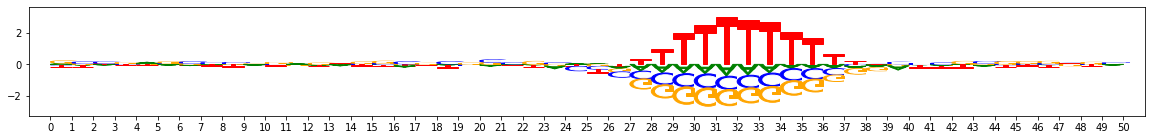

Actual importance scores:


<Figure size 432x288 with 0 Axes>

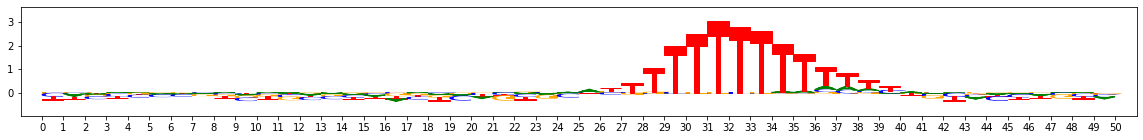

onehot, fwd and rev:


<Figure size 432x288 with 0 Axes>

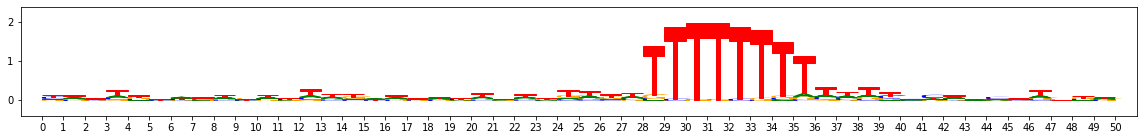

<Figure size 432x288 with 0 Axes>

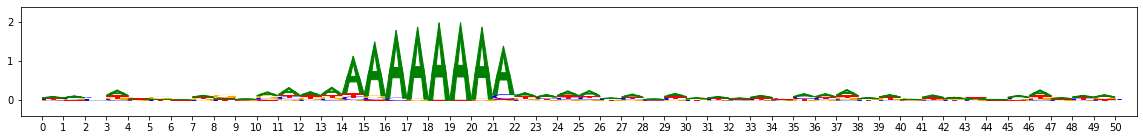

<Figure size 432x288 with 0 Axes>

In [ ]:
#26
run_modisco(hyp_impscores[:5000], impscores[:5000], onehot_data[:5000])